# Sanity check: lending club dataset with linear models

In [1]:
# limit the number of threads used by xgboost models
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"

# standard libaries
import sys
import copy
import dill
from collections import defaultdict
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# flow specific packages
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from flow import edge_credits2edge_credit
from on_manifold import OnManifoldExplainer, IndExplainer, FeatureAttribution
from linear_evaluation import get_error, get_indirect_effect_flow, get_effect_asv, get_effect_ind, get_effect_manifold, get_direct_effect_flow
from linear_evaluation import get_direct_effect_ground_truth, get_indirect_effect_ground_truth

np.random.seed(42)

## Dataset and Training

In [2]:
df = pd.read_csv('C:\gitlab\shaply_flow\data\lending_club_2012131415161718_credcard_debtconsol_input.csv')  
print(df.shape)

(940948, 17)


In [3]:
df.head(2)

,term_36m,term_60m,grade_n,sub_grade_n,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,emp_length_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n,loan_amnt_n,cover,Outcome
0,1,0,6,67,83.7,10.65,162.87,-1.0,10.0,27.65,-1,100,-1,24000.0,5000,4.800000,0
1,0,1,5,51,85.6,15.96,170.08,-1.0,8.0,23.51,-1,100,-1,47004.0,7000,6.714857,0


In [3]:
df.loc[:,'term_36m':'cover'].head(2)

,term_36m,term_60m,grade_n,sub_grade_n,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,emp_length_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n,loan_amnt_n,cover
0,1,0,6,67,83.7,10.65,162.87,-1.0,10.0,27.65,-1,100,-1,24000.0,5000,4.800000
1,0,1,5,51,85.6,15.96,170.08,-1.0,8.0,23.51,-1,100,-1,47004.0,7000,6.714857


In [4]:
X, y = df.loc[:,'term_36m':'cover'],df.iloc[:,16]
X_display,y_display = df.loc[:,'term_36m':'cover'],df.iloc[:,16]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=10000).fit(X_train, y_train)

## Explanation setting

In [5]:
nsamples = 10000 # paper: 1000 samples
nruns = 5 # number of monte carlo samples
sample_ind = 10
bg = X.fillna(X.mean()).sample(1) # background sample, no need for multiple sample because of the linearity axiom
fg = X[:nsamples] # foreground samples to explain

## Build a causal graph

In [6]:
## setting up enviroment for graph viz
os.environ["PATH"] += os.pathsep + 'C:/Users/vivianjiang/anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

learning dependency for term_36m: 100%|████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.81it/s]


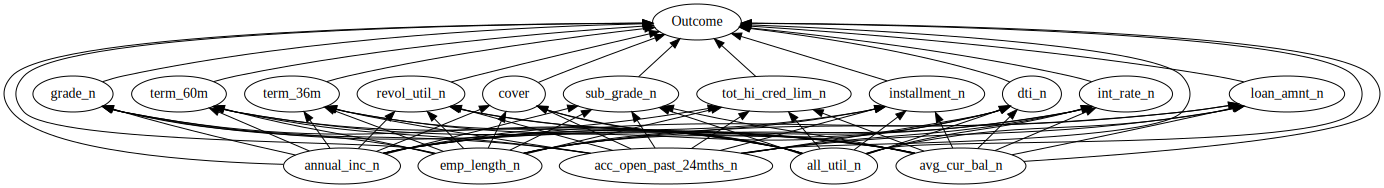

In [7]:
## Simple causal graph
causal_links = CausalLinks()
categorical_feature_names = [] # a linear model doesn't handle categorical features
display_translator = translator(X.columns, X, X_display)
target_name = 'Outcome' # 'predicted hazard'
feature_names = list(X.columns)
f = lambda x: x.dot(model.coef_.reshape(-1, 1)).ravel() + model.intercept_ # logit is linear log(p / 1-p)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_linear_f(feature_names, f))
A = ['annual_inc_n', 'emp_length_n','acc_open_past_24mths_n','all_util_n','avg_cur_bal_n']
D = list(set(feature_names) - set(A))
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name, method='linear')

causal_graph.draw()

0it [00:00, ?it/s]


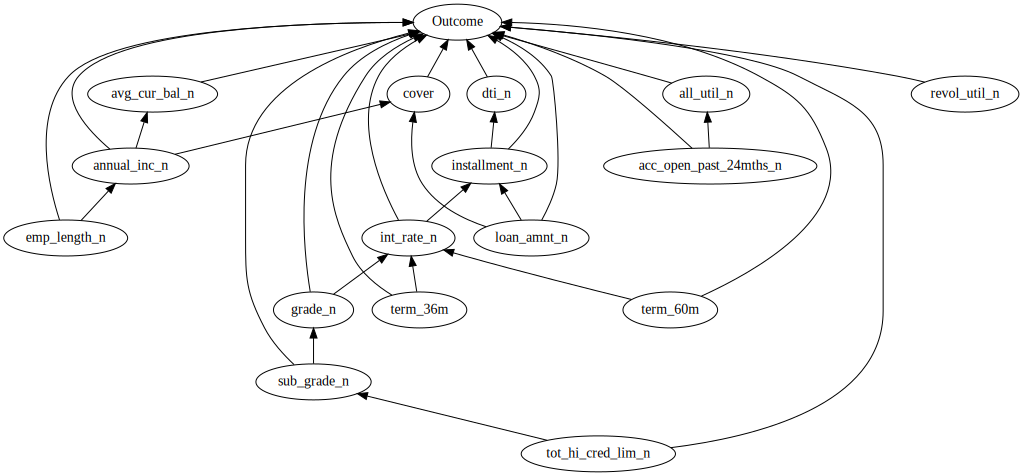

In [8]:
## Complex causal graph
causal_links = CausalLinks()
categorical_feature_names = [] # a linear model doesn't handle categorical features
display_translator = translator(X.columns, X, X_display)
target_name = 'Outcome' # 'predicted hazard'
feature_names = list(X.columns)
f = lambda x: x.dot(model.coef_.reshape(-1, 1)).ravel() + model.intercept_ # logit is linear log(p / 1-p)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_linear_f(feature_names, f))
causal_links.add_causes_effects('sub_grade_n', 'grade_n', lambda x: x)
causal_links.add_causes_effects('term_36m', 'int_rate_n', lambda x: x)
causal_links.add_causes_effects('term_60m', 'int_rate_n', lambda x: x)
causal_links.add_causes_effects('grade_n', 'int_rate_n', lambda x: x)
causal_links.add_causes_effects('int_rate_n', 'installment_n', lambda x: x)
causal_links.add_causes_effects('tot_hi_cred_lim_n', 'sub_grade_n', lambda x: x)
causal_links.add_causes_effects('installment_n', 'dti_n', lambda x: x)
causal_links.add_causes_effects('acc_open_past_24mths_n', 'all_util_n', lambda x: x)
causal_links.add_causes_effects('annual_inc_n', 'avg_cur_bal_n', lambda x: x)
causal_links.add_causes_effects('emp_length_n', 'annual_inc_n', lambda x: x)
causal_links.add_causes_effects('loan_amnt_n', 'installment_n', lambda x: x)
causal_links.add_causes_effects('annual_inc_n', 'cover', lambda x: x)
causal_links.add_causes_effects('loan_amnt_n', 'cover', lambda x: x)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name, method='linear')

causal_graph.draw()

## Explain

Flow, ASV, and SHAP converge in 1 run b/c the model is linear.

In [9]:
cf_flow_lc = GraphExplainer(causal_graph, bg, nruns=1).shap_values(fg)

maybe you want to skip prepare


TypeError: <lambda>() takes 1 positional argument but 2 were given

In [10]:
bg_on_manifold = X.fillna(X.mean()).sample(100) # used to learn conditional dependence
explainer = OnManifoldExplainer(f, pd.concat([bg, bg_on_manifold]), nruns=100, sigma_sq=0.1)  # need > 1 run b/c conditional expectation is non-linear
cf_on_manifold_lc = explainer.shap_values(fg)

manifold bg samples:   0%|▏                                                       | 29/10000 [00:18<1:46:09,  1.57it/s]


KeyboardInterrupt: 

In [11]:
explainer = IndExplainer(f, bg, nruns=1)
cf_ind_lc = explainer.shap_values(fg)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.83it/s]


## Compare baselines

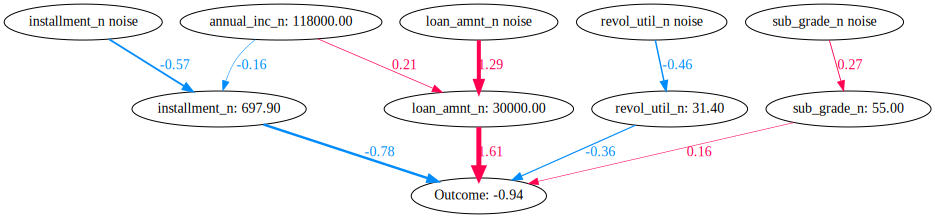

<AGraph <Swig Object of type 'Agraph_t *' at 0x00000285B7369180>>

In [72]:
sample_ind = 9000
cf_flow_lc.fold_noise=False
cf_flow_lc.draw(sample_ind, max_display=10)

on manifold


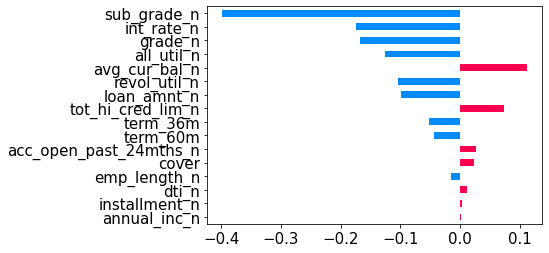

In [54]:
print('on manifold')
cf_on_manifold_lc.draw(sample_ind)

SHAP value


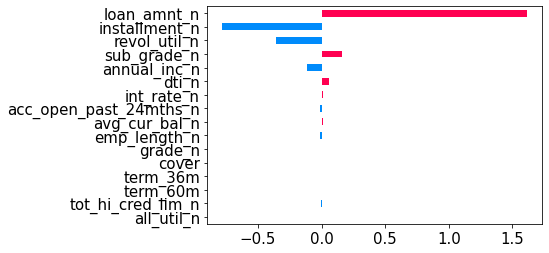

In [73]:
print('SHAP value')
cf_ind_lc.draw(sample_ind)

ASV


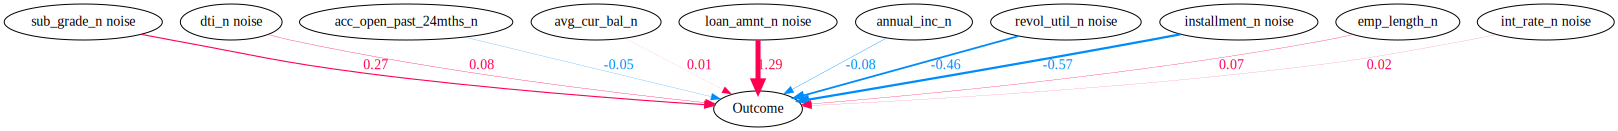

In [74]:
# asv
print('ASV')
cf_flow_lc.fold_noise = False
g = cf_flow_lc.draw_asv(sample_ind, max_display=10, show_fg_val=False)

## Calculate difference with the ground truth

In [57]:
gt = get_direct_effect_ground_truth(cf_flow_lc.graph)
theta_ind = get_effect_ind(cf_ind_lc)
theta_manifold = get_effect_manifold(cf_on_manifold_lc)
theta_asv = get_effect_asv(cf_flow_lc)
theta_flow = get_direct_effect_flow(cf_flow_lc)

gt_indirect = get_indirect_effect_ground_truth(cf_flow_lc.graph)
theta_flow_indirect = get_indirect_effect_flow(cf_flow_lc)

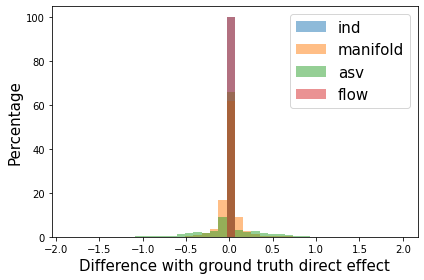

       ind: 0.0 ($\pm$ 0.0)
  manifold: 0.1 ($\pm$ 0.1)
       asv: 0.1 ($\pm$ 0.2)
      flow: 0.0 ($\pm$ 0.0)


In [58]:
errors = {
    'ind': get_error(gt, theta_ind),
    'manifold': get_error(gt, theta_manifold),
    'asv': get_error(gt, theta_asv),
    'flow': get_error(gt, theta_flow)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] # get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth direct effect', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.show()

for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")

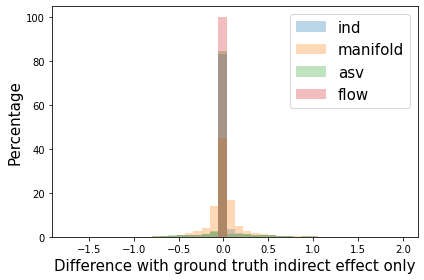

       ind: 0.1 ($\pm$ 0.2)
  manifold: 0.1 ($\pm$ 0.2)
       asv: 0.1 ($\pm$ 0.2)
      flow: 0.0 ($\pm$ 0.0)


In [59]:
errors = {
    'ind': get_error(gt_indirect, theta_ind),
    'manifold': get_error(gt_indirect, theta_manifold),
    'asv': get_error(gt_indirect, theta_asv),
    'flow': get_error(gt_indirect, theta_flow_indirect)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.3, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth indirect effect only', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.show()

for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")

Only Shapley Flow makes no mistake on both the direct and indirect effects.

### Investigate the background and foreground samples

In [60]:
bg_sample = bg.iloc[0]
pd.concat([X_display.iloc[bg_sample.name], X_display.iloc[sample_ind]], 1).rename(columns={bg_sample.name: "background sample", sample_ind: 'foreground sample'}).T

,term_36m,term_60m,grade_n,sub_grade_n,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,emp_length_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n,loan_amnt_n,cover
background sample,1.0,0.0,4.0,49.0,43.6,17.77,288.30,29188.0,0.5,22.13,1096.0,100.0,3.0,32000.0,8000.0,4.00000
foreground sample,1.0,0.0,7.0,77.0,35.9,6.62,271.73,-1.0,10.0,17.71,-1.0,100.0,-1.0,62000.0,8850.0,7.00565


### Import US Census data

In [18]:
df = pd.read_csv('Downloads\\archive\\adult.csv')
print(df.shape)

(32561, 15)


In [19]:
df.head(2)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K


### Pre-processing

In [20]:
## Drop column education.num - already covered by education
df = df.drop(columns = ['education.num'])

## Replace ? with nan in categorical features
df['workclass'] = df['workclass'].replace('?', np.NaN)
df['marital.status'] = df['marital.status'].replace('?', np.NaN)
df['occupation'] = df['occupation'].replace('?', np.NaN)
df['relationship'] = df['relationship'].replace('?', np.NaN)
df['race'] = df['race'].replace('?', np.NaN)
df['sex'] = df['sex'].replace('?', np.NaN)
df['native.country'] = df['native.country'].replace('?', np.NaN)

df['native.country'].loc[df['native.country'] == 'United-States'] = 'usa'
df['native.country'].loc[df['native.country'] != 'usa'] = 'non_usa'

## one hot encoding
df['country_enc'] = df['native.country'].map({'usa' : 1, 'non_usa' : 0})
df.drop(['native.country'], axis = 1, inplace = True)

df['sex_enc'] = df['sex'].map({'Male' : 1, 'Female' : 0})
df.drop(['sex'], axis = 1, inplace = True)

race_enc = (df.groupby('race').size()) / len(df)
print(race_enc,'\n')
df['race_enc'] = df['race'].apply(lambda x : race_enc[x])

relationship_enc = (df.groupby('relationship').size()) / len(df)
print(relationship_enc)
df['relationship_enc'] = df['relationship'].apply(lambda x : relationship_enc[x])

## drop some unethical columns
df.drop(['marital.status'], axis = 1, inplace = True)

race
Amer-Indian-Eskimo    0.009551
Asian-Pac-Islander    0.031909
Black                 0.095943
Other                 0.008323
White                 0.854274
dtype: float64 

relationship
Husband           0.405178
Not-in-family     0.255060
Other-relative    0.030128
Own-child         0.155646
Unmarried         0.105832
Wife              0.048156
dtype: float64


C:\Users\vivianjiang\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
## Create income 1/0 flag for modelling
df['income_mt30K'] = np.where(df.income == '>50K', 1, 0)
df = df.drop(columns = ['income'])

In [22]:
df['income_mt30K'].value_counts()

0    24720
1     7841
Name: income_mt30K, dtype: int64

In [23]:
df.head(2)

,age,workclass,fnlwgt,education,occupation,relationship,race,capital.gain,capital.loss,hours.per.week,country_enc,sex_enc,race_enc,relationship_enc,income_mt30K
0,90,NaN,77053,HS-grad,NaN,Not-in-family,White,0,4356,40,1,0,0.854274,0.25506,0
1,82,Private,132870,HS-grad,Exec-managerial,Not-in-family,White,0,4356,18,1,0,0.854274,0.25506,0


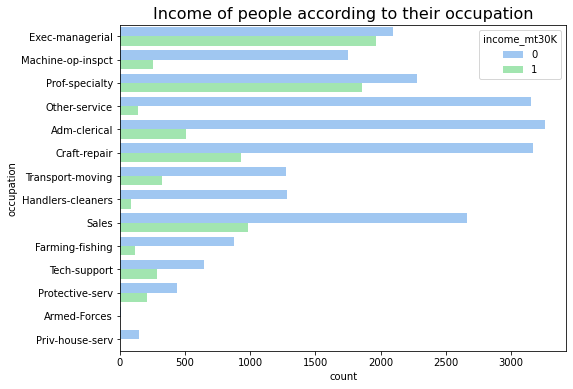

In [31]:
plt.style.use('seaborn-pastel')
plt.figure(figsize = (8,6))
plt.title("Income of people according to their occupation", fontsize = 16)
sns.countplot(y = df['occupation'], hue = df['income_mt30K'])
plt.show()

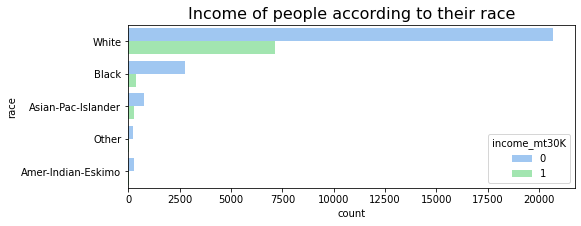

In [29]:
plt.style.use('seaborn-pastel')
plt.figure(figsize = (8,3))
plt.title("Income of people according to their race", fontsize = 16)
sns.countplot(y = df['race'], hue = df['income_mt30K'])
plt.show()

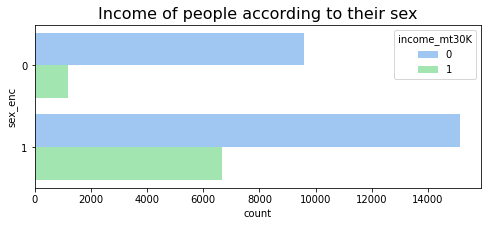

In [35]:
plt.style.use('seaborn-pastel')
plt.figure(figsize = (8,3))
plt.title("Income of people according to their sex", fontsize = 16)
sns.countplot(y = df['sex_enc'], hue = df['income_mt30K'])
plt.show()

### Build model

In [36]:
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor


def tree_shap_recursive(children_left, children_right, children_default, features, thresholds, values,
                        node_sample_weight,
                        x, x_missing, phi, node_index, unique_depth, parent_feature_indexes,
                        parent_zero_fractions, parent_one_fractions, parent_pweights, parent_zero_fraction,
                        parent_one_fraction, parent_feature_index, condition, condition_feature, condition_fraction):
    # stop if we have no weight coming down to us
    if condition_fraction == 0:
        return

    # extend the unique path
    feature_indexes = parent_feature_indexes[unique_depth + 1:]
    feature_indexes[:unique_depth + 1] = parent_feature_indexes[:unique_depth + 1]
    zero_fractions = parent_zero_fractions[unique_depth + 1:]
    zero_fractions[:unique_depth + 1] = parent_zero_fractions[:unique_depth + 1]
    one_fractions = parent_one_fractions[unique_depth + 1:]
    one_fractions[:unique_depth + 1] = parent_one_fractions[:unique_depth + 1]
    pweights = parent_pweights[unique_depth + 1:]
    pweights[:unique_depth + 1] = parent_pweights[:unique_depth + 1]

    if condition == 0 or condition_feature != parent_feature_index:
        extend_path(
            feature_indexes, zero_fractions, one_fractions, pweights,
            unique_depth, parent_zero_fraction, parent_one_fraction, parent_feature_index
        )

    split_index = features[node_index]

    # leaf node
    if children_right[node_index] == -1:
        for i in range(1, unique_depth + 1):
            w = unwound_path_sum(feature_indexes, zero_fractions, one_fractions, pweights, unique_depth, i)
            phi[feature_indexes[i]] += w * (one_fractions[i] - zero_fractions[i]) * values[
                node_index] * condition_fraction

    # internal node
    else:
        # find which branch is "hot" (meaning x would follow it)
        hot_index = 0
        cleft = children_left[node_index]
        cright = children_right[node_index]
        if x_missing[split_index] == 1:
            hot_index = children_default[node_index]
        elif x[split_index] < thresholds[node_index]:
            hot_index = cleft
        else:
            hot_index = cright
        cold_index = (cright if hot_index == cleft else cleft)
        w = node_sample_weight[node_index]
        hot_zero_fraction = node_sample_weight[hot_index] / w
        cold_zero_fraction = node_sample_weight[cold_index] / w
        incoming_zero_fraction = 1
        incoming_one_fraction = 1

        # see if we have already split on this feature,
        # if so we undo that split so we can redo it for this node
        path_index = 0
        while (path_index <= unique_depth):
            if feature_indexes[path_index] == split_index:
                break
            path_index += 1

        if path_index != unique_depth + 1:
            incoming_zero_fraction = zero_fractions[path_index]
            incoming_one_fraction = one_fractions[path_index]
            unwind_path(feature_indexes, zero_fractions, one_fractions, pweights, unique_depth, path_index)
            unique_depth -= 1

        # divide up the condition_fraction among the recursive calls
        hot_condition_fraction = condition_fraction
        cold_condition_fraction = condition_fraction
        if condition > 0 and split_index == condition_feature:
            cold_condition_fraction = 0
            unique_depth -= 1
        elif condition < 0 and split_index == condition_feature:
            hot_condition_fraction *= hot_zero_fraction
            cold_condition_fraction *= cold_zero_fraction
            unique_depth -= 1

        tree_shap_recursive(
            children_left, children_right, children_default, features, thresholds, values, node_sample_weight,
            x, x_missing, phi, hot_index, unique_depth + 1,
            feature_indexes, zero_fractions, one_fractions, pweights,
                                          hot_zero_fraction * incoming_zero_fraction, incoming_one_fraction,
            split_index, condition, condition_feature, hot_condition_fraction
        )

        tree_shap_recursive(
            children_left, children_right, children_default, features, thresholds, values, node_sample_weight,
            x, x_missing, phi, cold_index, unique_depth + 1,
            feature_indexes, zero_fractions, one_fractions, pweights,
                                           cold_zero_fraction * incoming_zero_fraction, 0,
            split_index, condition, condition_feature, cold_condition_fraction
        )


def compute_expectations(children_left, children_right, node_sample_weight, values, i, depth=0):
    # Leaf node set leaf node value to themselves and return a depth of 0
    if children_right[i] == -1:
        values[i] = values[i]
        return 0
    else:
        # Get left and right indices
        li = children_left[i]
        ri = children_right[i]
        # Left max distance from a leaf (unrelated to calculation)
        depth_left = compute_expectations(children_left, children_right, node_sample_weight, values, li, depth + 1)
        # Right max distance from a leaf
        depth_right = compute_expectations(children_left, children_right, node_sample_weight, values, ri, depth + 1)
        left_weight = node_sample_weight[li]
        right_weight = node_sample_weight[ri]
        # Computes expectation of a node value by weighted samples
        v = (left_weight * values[li] + right_weight * values[ri]) / (left_weight + right_weight)
        values[i] = v
        return max(depth_left, depth_right) + 1


class Tree:
    def __init__(self, children_left, children_right, children_default, feature, threshold, value, node_sample_weight):
        self.children_left = children_left.astype(np.int32)
        self.children_right = children_right.astype(np.int32)
        self.children_default = children_default.astype(np.int32)
        self.features = feature.astype(np.int32)
        self.thresholds = threshold
        self.values = value
        self.node_sample_weight = node_sample_weight

        self.max_depth = compute_expectations(
            self.children_left, self.children_right, self.node_sample_weight,
            self.values, 0
        )

    def __init__(self, tree):
        if str(type(tree)).endswith("'sklearn.tree._tree.Tree'>"):
            self.children_left = tree.children_left.astype(np.int32)  # children_left[i] holds the node id of the left child of node i, -1 is LEAF, children_left[i] > i since PRE-ORDER TRAVERSAL
            self.children_right = tree.children_right.astype(np.int32)  #children_right[i] holds the node id of the right child of node i, -1 is LEAF, children_right[i] > i since PRE-ORDER TRAVERSAL
            self.children_default = self.children_left  # missing values not supported in sklearn
            self.features = tree.feature.astype(np.int32)  # feature[i] holds the feature to split on, for the internal node i. (i.e. columns index by 0)
            self.thresholds = tree.threshold.astype(np.float64)  # threshold[i] holds the threshold for the internal node i, assuming it's check with <
            self.values = tree.value[:, 0, 0]  # assume only a single output for now,  Contains the constant prediction value of each node.
            self.node_sample_weight = tree.weighted_n_node_samples.astype(np.float64)  # weighted_n_node_samples[i] holds the weighted number of training samples reaching node i.

            # we recompute the expectations to make sure they follow the SHAP logic
            self.max_depth = compute_expectations(
                self.children_left, self.children_right, self.node_sample_weight,
                self.values, 0
            )


def unwound_path_sum(feature_indexes, zero_fractions, one_fractions, pweights, unique_depth, path_index):
    one_fraction = one_fractions[path_index]
    zero_fraction = zero_fractions[path_index]
    next_one_portion = pweights[unique_depth]
    total = 0

    for i in range(unique_depth - 1, -1, -1):
        if one_fraction != 0:
            tmp = next_one_portion * (unique_depth + 1) / ((i + 1) * one_fraction)
            total += tmp
            next_one_portion = pweights[i] - tmp * zero_fraction * ((unique_depth - i) / (unique_depth + 1))
        else:
            total += (pweights[i] / zero_fraction) / ((unique_depth - i) / (unique_depth + 1))

    return total


def unwind_path(feature_indexes, zero_fractions, one_fractions, pweights,
                unique_depth, path_index):
    one_fraction = one_fractions[path_index]
    zero_fraction = zero_fractions[path_index]
    next_one_portion = pweights[unique_depth]

    for i in range(unique_depth - 1, -1, -1):
        if one_fraction != 0:
            tmp = pweights[i]
            pweights[i] = next_one_portion * (unique_depth + 1) / ((i + 1) * one_fraction)
            next_one_portion = tmp - pweights[i] * zero_fraction * (unique_depth - i) / (unique_depth + 1)
        else:
            pweights[i] = (pweights[i] * (unique_depth + 1)) / (zero_fraction * (unique_depth - i))

    for i in range(path_index, unique_depth):
        feature_indexes[i] = feature_indexes[i + 1]
        zero_fractions[i] = zero_fractions[i + 1]
        one_fractions[i] = one_fractions[i + 1]


def extend_path(feature_indexes, zero_fractions, one_fractions, pweights,
                unique_depth, zero_fraction, one_fraction, feature_index):
    feature_indexes[unique_depth] = feature_index
    zero_fractions[unique_depth] = zero_fraction
    one_fractions[unique_depth] = one_fraction
    if unique_depth == 0:
        pweights[unique_depth] = 1
    else:
        pweights[unique_depth] = 0

    for i in range(unique_depth - 1, -1, -1):
        pweights[i + 1] += one_fraction * pweights[i] * (i + 1) / (unique_depth + 1)
        pweights[i] = zero_fraction * pweights[i] * (unique_depth - i) / (unique_depth + 1)


class TreeExplainer:
    def __init__(self, model):

        self.trees = [Tree(e.tree_) for e in model.estimators_]

        # Preallocate space for the unique path data
        maxd = np.max([t.max_depth for t in self.trees]) + 2
        print(maxd)
        # s = 1 + 2 + ... + maxd
        s = (maxd * (maxd + 1)) // 2
        self.feature_indexes = np.zeros(s, dtype=np.int32)
        self.zero_fractions = np.zeros(s, dtype=np.float64)
        self.one_fractions = np.zeros(s, dtype=np.float64)
        self.pweights = np.zeros(s, dtype=np.float64)

    def shap_values(self, X, **kwargs):
        # convert dataframes
        if str(type(X)).endswith("pandas.core.series.Series'>"):
            X = X.values
        elif str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            X = X.values

        assert str(type(X)).endswith("'numpy.ndarray'>"), "Unknown instance type: " + str(type(X))
        assert len(X.shape) == 1 or len(X.shape) == 2, "Instance must have 1 or 2 dimensions!"

        # single instance
        if len(X.shape) == 1:
            # phi is +1 in size compared to X
            phi = np.zeros(X.shape[0] + 1)
            x_missing = np.zeros(X.shape[0], dtype=np.bool)
            for t in self.trees:
                self.tree_shap(t, X, x_missing, phi)
            phi /= len(self.trees)
        elif len(X.shape) == 2:
            phi = np.zeros((X.shape[0], X.shape[1] + 1))
            x_missing = np.zeros(X.shape[1], dtype=np.bool)
            for i in range(X.shape[0]):
                for t in self.trees:
                    self.tree_shap(t, X[i, :], x_missing, phi[i, :])
            phi /= len(self.trees)
        return phi

    def tree_shap(self, tree, x, x_missing, phi, condition=0, condition_feature=0):

        # update the bias term, which is the last index in phi
        # (note the paper has this as phi_0 instead of phi_M)
        if condition == 0:
            phi[-1] += tree.values[0]

        # start the recursive algorithm
        tree_shap_recursive(
            tree.children_left, tree.children_right, tree.children_default, tree.features,
            tree.thresholds, tree.values, tree.node_sample_weight,
            x, x_missing, phi, 0, 0, self.feature_indexes, self.zero_fractions, self.one_fractions, self.pweights,
            1, 1, -1, condition, condition_feature, 1
        )

In [ ]:
features= df.colnames
target = ['Survived']

In [ ]:
X,y =  df[features], df_raw_intime[target]

In [ ]:


model = RandomForestRegressor(n_estimators=2, max_depth=3)
model.fit(X, y)

x = np.ones(X.shape[1])
print(TreeExplainer(model).shap_values(x))